<a href="https://colab.research.google.com/github/marreapato/Forecasting-BVSP-Deep-Learning/blob/main/15_lags_Aplica%C3%A7%C3%A3o_Auto_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tentando Aplicar o Shap

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data = data[['Close']]

# Set the lag to 60 days
lag = 15

# Create a lagged version of the time series
#data['Close_lagged'] = data['Close'].shift(lag)

# Drop NaN values introduced by the lag
#data = data.dropna()

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

# Fit an AutoARIMA model
model = pm.auto_arima(train['Close'], seasonal=True, m=lag)

# Predict the future values
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Forecast'])

test['forecast']=forecast.values

[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-2-49389d21d072>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast']=forecast.values


In [3]:
model

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 15),
      suppress_warnings=True, with_intercept=False)

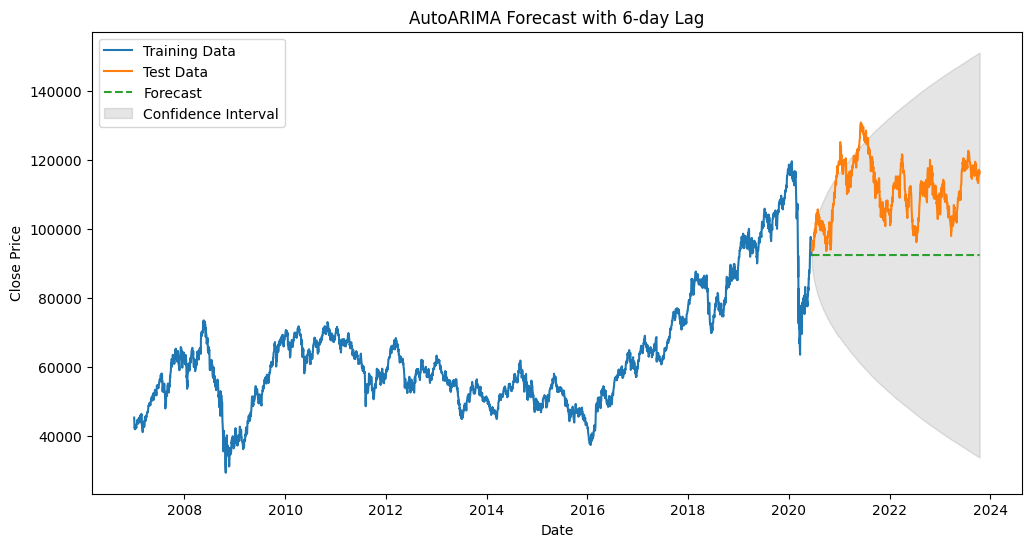

In [4]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Test Data')
plt.plot(test['forecast'], label='Forecast', linestyle='dashed')#
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1, label='Confidence Interval')
plt.title('AutoARIMA Forecast with 6-day Lag')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [5]:

# Calculate and print the mean squared error
arima_mse = mean_squared_error(test['Close'], forecast.values)

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(arima_mse))

GRU Model RMSE:  20434.374949795565


In [6]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

arima_mape = calculate_mape(test['Close'], forecast.values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAPE: {:.2f}%".format(arima_mape))


ARIMA Model MAPE: 16.43%


In [7]:
def calculate_mae(true_values, predicted_values):
    abs_errors = np.abs(true_values - predicted_values)
    mae = np.mean(abs_errors)
    return mae

# Example usage:
arima_mae = calculate_mae(test['Close'], forecast.values)
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arima_mae))

ARIMA Model MAE: 18756.68


In [8]:
# Calculate the MASE for each model
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

arima_mase = calculate_mase(arima_mae, 15143.23)

# Compare the models using Mean Absolute Scaled Error
print("ARIMA Model MASE: {:.2f}".format(arima_mase))


ARIMA Model MASE: 1.24


# Modelo Híbrido

In [ ]:
#!pip install  keras-self-attention


Epoch 1/300
52/52 [==============================] - 9s 7ms/step - loss: 0.0173
Epoch 2/300
52/52 [==============================] - 0s 7ms/step - loss: 4.6999e-04
Epoch 3/300
52/52 [==============================] - 0s 7ms/step - loss: 3.6408e-04
Epoch 4/300
52/52 [==============================] - 0s 7ms/step - loss: 3.5327e-04
Epoch 5/300
52/52 [==============================] - 0s 7ms/step - loss: 3.4060e-04
Epoch 6/300
52/52 [==============================] - 0s 6ms/step - loss: 3.2662e-04
Epoch 7/300
52/52 [==============================] - 0s 7ms/step - loss: 3.1206e-04
Epoch 8/300
52/52 [==============================] - 0s 7ms/step - loss: 2.9305e-04
Epoch 9/300
52/52 [==============================] - 0s 6ms/step - loss: 2.6838e-04
Epoch 10/300
52/52 [==============================] - 0s 5ms/step - loss: 2.4654e-04
Epoch 11/300
52/52 [==============================] - 0s 5ms/step - loss: 2.1410e-04
Epoch 12/300
52/52 [==============================] - 0s 5ms/step - loss: 1.84

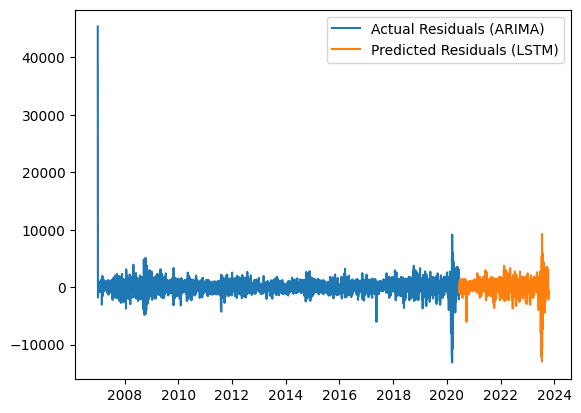

In [9]:
# Get the residuals from the ARIMA model
residuals_arima = model.resid()

# Normalize the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_arima_normalized = scaler.fit_transform(residuals_arima.values.reshape(-1, 1))

# Build an LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(residuals_arima_normalized.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for LSTM input
X_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1, 1))
y_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1))

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=300, batch_size=64)

# Predict the residuals using the LSTM model
X_test = np.reshape(residuals_arima_normalized[-len(test):], (len(test), 1, 1))
residuals_lstm_normalized = model_lstm.predict(X_test)
residuals_lstm = scaler.inverse_transform(residuals_lstm_normalized)

# Plot the actual residuals and predicted residuals
plt.plot(residuals_arima.index, residuals_arima.values, label='Actual Residuals (ARIMA)')
plt.plot(test.index, residuals_lstm, label='Predicted Residuals (LSTM)')
plt.legend()
plt.show()

Epoch 1/300
52/52 [==============================] - 4s 5ms/step - loss: 0.0069
Epoch 2/300
52/52 [==============================] - 0s 5ms/step - loss: 3.2326e-04
Epoch 3/300
52/52 [==============================] - 0s 4ms/step - loss: 2.8714e-04
Epoch 4/300
52/52 [==============================] - 0s 5ms/step - loss: 2.6388e-04
Epoch 5/300
52/52 [==============================] - 0s 5ms/step - loss: 2.3648e-04
Epoch 6/300
52/52 [==============================] - 0s 5ms/step - loss: 2.0425e-04
Epoch 7/300
52/52 [==============================] - 0s 5ms/step - loss: 1.6967e-04
Epoch 8/300
52/52 [==============================] - 0s 5ms/step - loss: 1.3064e-04
Epoch 9/300
52/52 [==============================] - 0s 4ms/step - loss: 9.3636e-05
Epoch 10/300
52/52 [==============================] - 0s 5ms/step - loss: 6.0427e-05
Epoch 11/300
52/52 [==============================] - 0s 5ms/step - loss: 3.2340e-05
Epoch 12/300
52/52 [==============================] - 0s 5ms/step - loss: 1.55

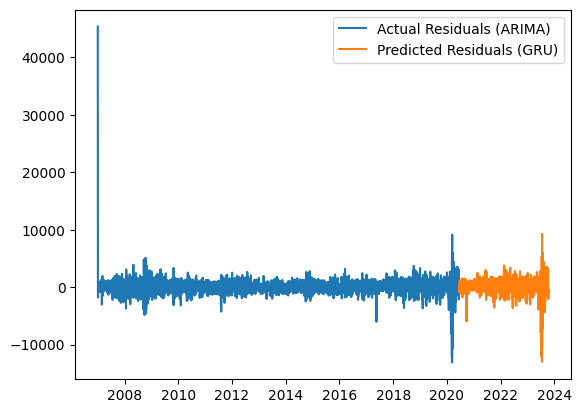

In [10]:
# Get the residuals from the ARIMA model
residuals_arima = model.resid()

# Normalize the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_arima_normalized = scaler.fit_transform(residuals_arima.values.reshape(-1, 1))

# Build a GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(residuals_arima_normalized.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for GRU input
X_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1, 1))
y_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1))

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=300, batch_size=64)

# Predict the residuals using the GRU model
X_test = np.reshape(residuals_arima_normalized[-len(test):], (len(test), 1, 1))
residuals_gru_normalized = model_gru.predict(X_test)
residuals_gru = scaler.inverse_transform(residuals_gru_normalized)

# Plot the actual residuals and predicted residuals
plt.plot(residuals_arima.index, residuals_arima.values, label='Actual Residuals (ARIMA)')
plt.plot(test.index, residuals_gru, label='Predicted Residuals (GRU)')
plt.legend()
plt.show()


In [11]:
test['Forecast Hybrid'] = test['forecast'].values+np.hstack(residuals_lstm)
test['Forecast Hybrid Gru'] = test['forecast'].values+np.hstack(residuals_gru)

<ipython-input-11-021239764f03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast Hybrid'] = test['forecast'].values+np.hstack(residuals_lstm)
<ipython-input-11-021239764f03>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast Hybrid Gru'] = test['forecast'].values+np.hstack(residuals_gru)


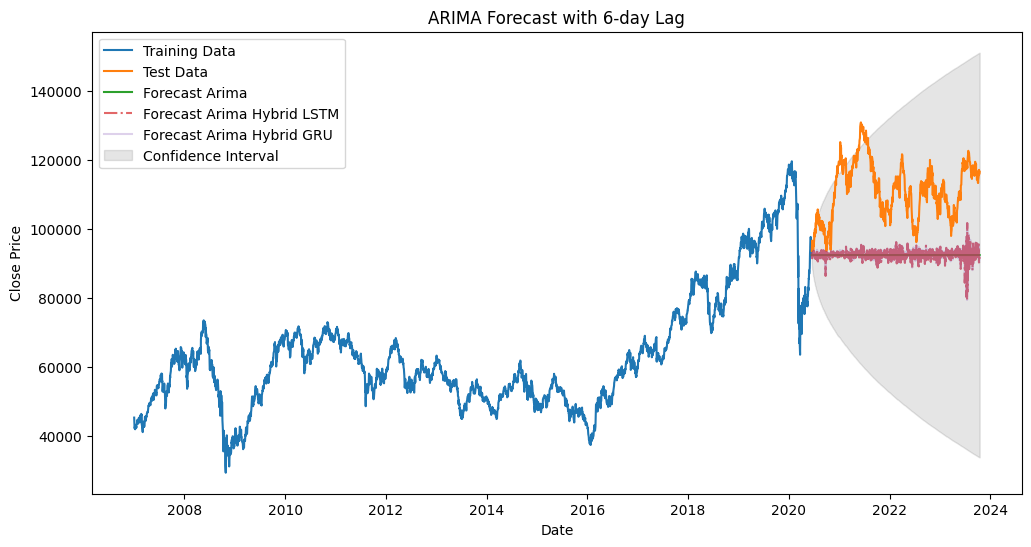

In [12]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Test Data')
plt.plot(test['forecast'], label='Forecast Arima', linestyle='solid')#
plt.plot(test['Forecast Hybrid'], label='Forecast Arima Hybrid LSTM', linestyle='dashdot',alpha=0.7)#
plt.plot(test['Forecast Hybrid Gru'], label='Forecast Arima Hybrid GRU', linestyle='solid',alpha=0.3)#
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1, label='Confidence Interval')
plt.title('ARIMA Forecast with 6-day Lag')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [13]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

arimah_mape = calculate_mape(test['Close'], test['Forecast Hybrid'].values)
arimahg_mape = calculate_mape(test['Close'], test['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAPE: {:.2f}%".format(arimah_mape))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Gru Model MAPE: {:.2f}%".format(arimahg_mape))


ARIMA Model MAPE: 16.40%
ARIMA Gru Model MAPE: 16.34%


In [14]:
def calculate_mae(true_values, predicted_values):
    abs_errors = np.abs(true_values - predicted_values)
    mae = np.mean(abs_errors)
    return mae

# Example usage:
arimah_mae = calculate_mae(test['Close'], test['Forecast Hybrid'].values)
arimahg_mae = calculate_mae(test['Close'], test['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arimah_mae))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arimahg_mae))

ARIMA Model MAE: 18728.31
ARIMA Model MAE: 18658.13


In [15]:
# Calculate the MASE for each model
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

# Example usage:
arimah_mase = calculate_mase(arimah_mae,15143.23)
arimahg_mase = calculate_mase(arimahg_mae,15143.23)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MASE: {:.2f}".format(arimah_mase))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA gru Model MASE: {:.2f}".format(arimahg_mase))


ARIMA Model MASE: 1.24
ARIMA gru Model MASE: 1.23


In [16]:

# Calculate and print the mean squared error
arimah_mse = mean_squared_error(test['Close'], test['Forecast Hybrid'].values)

# Calculate and print the mean squared error
arimahg_mse = mean_squared_error(test['Close'], test['Forecast Hybrid Gru'].values)

# Compare the models using Mean Squared Error
print("LSTM Arima Model RMSE: ", np.sqrt(arimah_mse))
# Compare the models using Mean Squared Error
print("Gru Arima Model RMSE: ", np.sqrt(arimahg_mse))

LSTM Arima Model RMSE:  20469.58197901762
Gru Arima Model RMSE:  20405.521141470443


prox 3 dias

In [17]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2test = yf.download('^BVSP', '2023-10-18', '2023-10-21')
data2test= data2test[['Close']]
len(data2test)

[*********************100%%**********************]  1 of 1 completed


3

In [18]:
data

,Close
Date,
2007-01-02,45383.0
2007-01-03,44445.0
2007-01-04,44020.0
2007-01-05,42245.0
2007-01-08,42830.0
...,...
2023-10-09,115156.0
2023-10-10,116737.0
2023-10-11,117051.0


In [19]:
data2test

,Close
Date,
2023-10-18,114060.0
2023-10-19,114004.0
2023-10-20,113155.0


In [20]:
# Fit an AutoARIMA model
model = pm.auto_arima(data, seasonal=True, m=lag)

# Predict the future values
forecast, conf_int = model.predict(n_periods=3, return_conf_int=True)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast.values, index=data2test.index, columns=['Forecast'])

forecast_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Forecast
Date,
2023-10-18,116405.571866
2023-10-19,116482.175213
2023-10-20,116457.567482


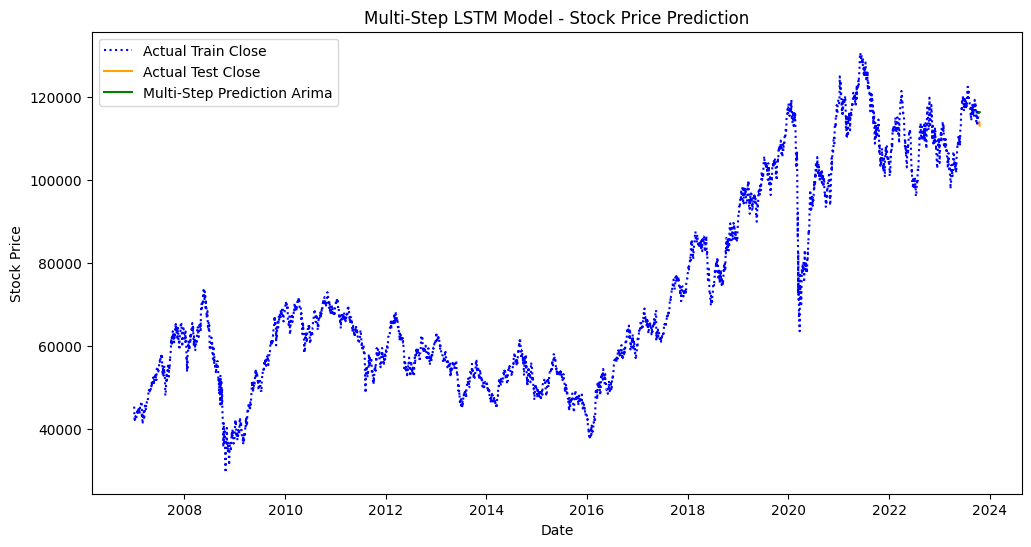

In [21]:
# Generate future dates for the multi-step prediction
#last_date = lagged_data.index[-1]
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_steps)


#Inverse transform both train and test data
#trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
#testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = data.index
time_index_test = data2test.index

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, data, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, data2test, label='Actual Test Close', color='orange')

# Plot the multi-step predictions
#plt.figure(figsize=(12, 6))
#plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(time_index_test, forecast, label='Multi-Step Prediction Arima',color='green')

plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Epoch 1/300
65/65 [==============================] - 3s 5ms/step - loss: 0.0059
Epoch 2/300
65/65 [==============================] - 0s 7ms/step - loss: 3.1396e-04
Epoch 3/300
65/65 [==============================] - 0s 6ms/step - loss: 2.8679e-04
Epoch 4/300
65/65 [==============================] - 0s 6ms/step - loss: 2.5133e-04
Epoch 5/300
65/65 [==============================] - 0s 6ms/step - loss: 2.1236e-04
Epoch 6/300
65/65 [==============================] - 0s 6ms/step - loss: 1.6444e-04
Epoch 7/300
65/65 [==============================] - 0s 7ms/step - loss: 1.1631e-04
Epoch 8/300
65/65 [==============================] - 0s 6ms/step - loss: 7.0374e-05
Epoch 9/300
65/65 [==============================] - 0s 7ms/step - loss: 3.3090e-05
Epoch 10/300
65/65 [==============================] - 0s 6ms/step - loss: 1.2025e-05
Epoch 11/300
65/65 [==============================] - 0s 4ms/step - loss: 3.8223e-06
Epoch 12/300
65/65 [==============================] - 0s 4ms/step - loss: 2.00

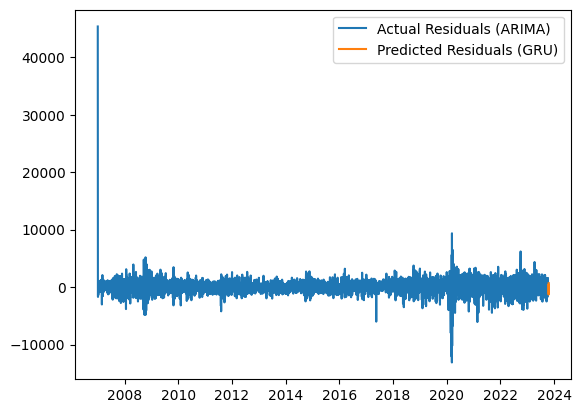

In [22]:
# Get the residuals from the ARIMA model
residuals_arima = model.resid()

# Normalize the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_arima_normalized = scaler.fit_transform(residuals_arima.values.reshape(-1, 1))

# Build a GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(residuals_arima_normalized.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for GRU input
X_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1, 1))
y_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1))

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=300, batch_size=64)

# Predict the residuals using the GRU model
X_test = np.reshape(residuals_arima_normalized[-len(data2test):], (len(data2test), 1, 1))
residuals_gru_normalized = model_gru.predict(X_test)
residuals_gru = scaler.inverse_transform(residuals_gru_normalized)

# Plot the actual residuals and predicted residuals
plt.plot(residuals_arima.index, residuals_arima.values, label='Actual Residuals (ARIMA)')
plt.plot(data2test.index, residuals_gru, label='Predicted Residuals (GRU)')
plt.legend()
plt.show()


Epoch 1/300
65/65 [==============================] - 5s 7ms/step - loss: 0.0128
Epoch 2/300
65/65 [==============================] - 0s 6ms/step - loss: 3.8436e-04
Epoch 3/300
65/65 [==============================] - 0s 5ms/step - loss: 3.6386e-04
Epoch 4/300
65/65 [==============================] - 0s 5ms/step - loss: 3.4698e-04
Epoch 5/300
65/65 [==============================] - 0s 5ms/step - loss: 3.2438e-04
Epoch 6/300
65/65 [==============================] - 0s 5ms/step - loss: 3.0554e-04
Epoch 7/300
65/65 [==============================] - 0s 5ms/step - loss: 2.7180e-04
Epoch 8/300
65/65 [==============================] - 0s 5ms/step - loss: 2.3628e-04
Epoch 9/300
65/65 [==============================] - 0s 5ms/step - loss: 1.9293e-04
Epoch 10/300
65/65 [==============================] - 0s 5ms/step - loss: 1.4753e-04
Epoch 11/300
65/65 [==============================] - 0s 5ms/step - loss: 9.5340e-05
Epoch 12/300
65/65 [==============================] - 0s 5ms/step - loss: 5.29

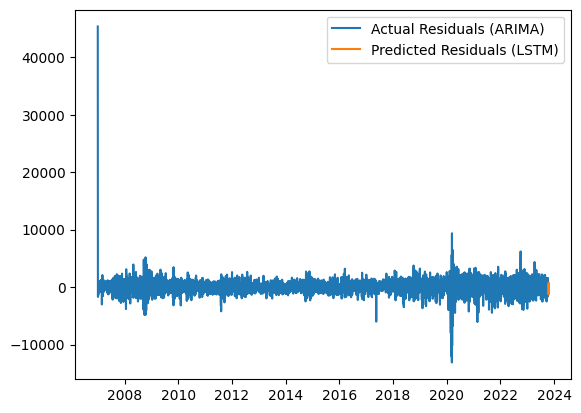

In [23]:
# Get the residuals from the ARIMA model
residuals_arima = model.resid()

# Normalize the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_arima_normalized = scaler.fit_transform(residuals_arima.values.reshape(-1, 1))

# Build an LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(residuals_arima_normalized.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for LSTM input
X_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1, 1))
y_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1))

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=300, batch_size=64)

# Predict the residuals using the LSTM model
X_test = np.reshape(residuals_arima_normalized[-len(data2test):], (len(data2test), 1, 1))
residuals_lstm_normalized = model_lstm.predict(X_test)
residuals_lstm = scaler.inverse_transform(residuals_lstm_normalized)

# Plot the actual residuals and predicted residuals
plt.plot(residuals_arima.index, residuals_arima.values, label='Actual Residuals (ARIMA)')
plt.plot(data2test.index, residuals_lstm, label='Predicted Residuals (LSTM)')
plt.legend()
plt.show()

In [24]:
forecast_df['Forecast Hybrid'] = forecast_df['Forecast'].values+np.hstack(residuals_lstm)
forecast_df['Forecast Hybrid Gru'] = forecast_df['Forecast'].values+np.hstack(residuals_gru)

In [25]:

# Calculate and print the mean squared error
arima_mse = mean_squared_error(data2test['Close'], forecast.values)

arimah_rmse = mean_squared_error(data2test['Close'], forecast_df['Forecast Hybrid'].values)
arimahg_rmse = mean_squared_error(data2test['Close'], forecast_df['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model rmse:",np.sqrt(arimah_rmse))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Gru Model rmse:",np.sqrt(arimahg_rmse))

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(arima_mse))

ARIMA Model rmse: 2880.885935275633
ARIMA Gru Model rmse: 2861.7194080714316
GRU Model RMSE:  2741.6547154235263


In [26]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

arima_mape = calculate_mape(data2test['Close'], forecast.values)
arimah_mape = calculate_mape(data2test['Close'], forecast_df['Forecast Hybrid'].values)
arimahg_mape = calculate_mape(data2test['Close'], forecast_df['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAPE: {:.2f}%".format(arimah_mape))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Gru Model MAPE: {:.2f}%".format(arimahg_mape))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAPE: {:.2f}%".format(arima_mape))


ARIMA Model MAPE: 2.33%
ARIMA Gru Model MAPE: 2.31%
ARIMA Model MAPE: 2.38%


In [27]:
def calculate_mae(true_values, predicted_values):
    abs_errors = np.abs(true_values - predicted_values)
    mae = np.mean(abs_errors)
    return mae


# Example usage:
arimah_mae = calculate_mae(data2test['Close'], forecast_df['Forecast Hybrid'].values)
arimahg_mae = calculate_mae(data2test['Close'], forecast_df['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arimah_mae))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arimahg_mae))
# Example usage:
arima_mae = calculate_mae(data2test['Close'], forecast.values)
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arima_mae))

ARIMA Model MAE: 2646.53
ARIMA Model MAE: 2625.79
ARIMA Model MAE: 2708.77


In [28]:
# Calculate the MASE for each model
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

arima_mase = calculate_mase(arima_mae, 1330)
# Example usage:
arimah_mase = calculate_mase(arimah_mae,1330)
arimahg_mase = calculate_mase(arimahg_mae,1330)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MASE: {:.2f}".format(arimah_mase))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA gru Model MASE: {:.2f}".format(arimahg_mase))

# Compare the models using Mean Absolute Scaled Error
print("ARIMA Model MASE: {:.2f}".format(arima_mase))


ARIMA Model MASE: 1.99
ARIMA gru Model MASE: 1.97
ARIMA Model MASE: 2.04


# 7 Dias

In [29]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2test = yf.download('^BVSP', '2023-10-18', '2023-10-27')
data2test= data2test[['Close']]
len(data2test)

[*********************100%%**********************]  1 of 1 completed


7

In [30]:
data

,Close
Date,
2007-01-02,45383.0
2007-01-03,44445.0
2007-01-04,44020.0
2007-01-05,42245.0
2007-01-08,42830.0
...,...
2023-10-09,115156.0
2023-10-10,116737.0
2023-10-11,117051.0


In [31]:
data2test

,Close
Date,
2023-10-18,114060.0
2023-10-19,114004.0
2023-10-20,113155.0
2023-10-23,112785.0
2023-10-24,113762.0
2023-10-25,112830.0
2023-10-26,114777.0


In [32]:
# Fit an AutoARIMA model
#model = pm.auto_arima(data, seasonal=True, m=lag)

# Predict the future values
forecast, conf_int = model.predict(n_periods=7, return_conf_int=True)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast.values, index=data2test.index, columns=['Forecast'])

forecast_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Forecast
Date,
2023-10-18,116405.571866
2023-10-19,116482.175213
2023-10-20,116457.567482
2023-10-23,116440.444218
2023-10-24,116483.695212
2023-10-25,116430.583228
2023-10-26,116480.068793


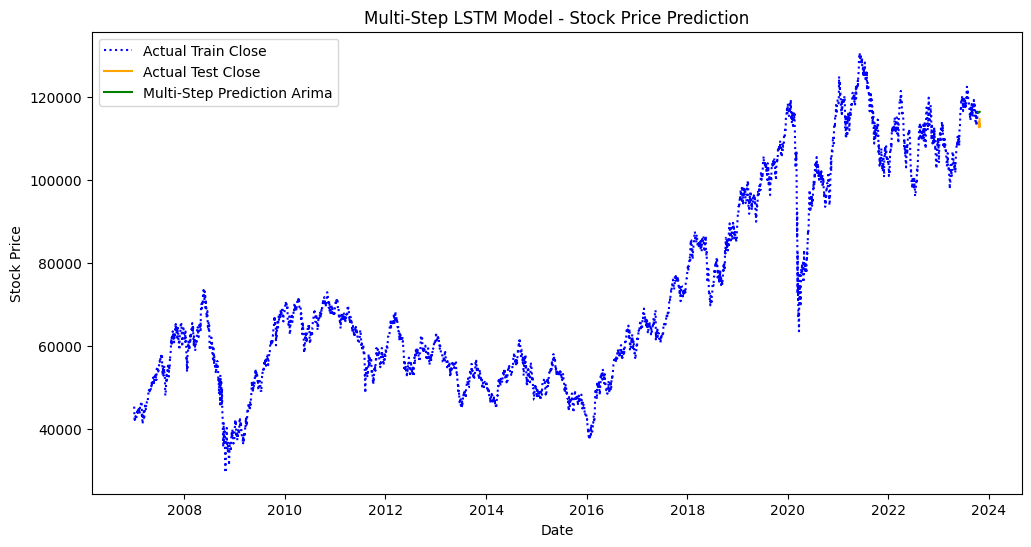

In [33]:
# Generate future dates for the multi-step prediction
#last_date = lagged_data.index[-1]
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_steps)


#Inverse transform both train and test data
#trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
#testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = data.index
time_index_test = data2test.index

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, data, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, data2test, label='Actual Test Close', color='orange')

# Plot the multi-step predictions
#plt.figure(figsize=(12, 6))
#plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(time_index_test, forecast, label='Multi-Step Prediction Arima',color='green')

plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Epoch 1/300
65/65 [==============================] - 4s 5ms/step - loss: 0.0059
Epoch 2/300
65/65 [==============================] - 0s 6ms/step - loss: 3.3734e-04
Epoch 3/300
65/65 [==============================] - 0s 6ms/step - loss: 3.0640e-04
Epoch 4/300
65/65 [==============================] - 0s 6ms/step - loss: 2.7109e-04
Epoch 5/300
65/65 [==============================] - 0s 6ms/step - loss: 2.2482e-04
Epoch 6/300
65/65 [==============================] - 0s 6ms/step - loss: 1.8073e-04
Epoch 7/300
65/65 [==============================] - 0s 6ms/step - loss: 1.2146e-04
Epoch 8/300
65/65 [==============================] - 0s 6ms/step - loss: 6.8001e-05
Epoch 9/300
65/65 [==============================] - 0s 6ms/step - loss: 2.9218e-05
Epoch 10/300
65/65 [==============================] - 0s 5ms/step - loss: 8.9664e-06
Epoch 11/300
65/65 [==============================] - 0s 4ms/step - loss: 1.8633e-06
Epoch 12/300
65/65 [==============================] - 0s 5ms/step - loss: 1.14

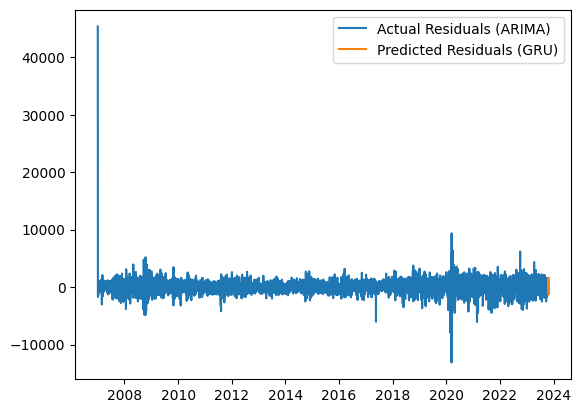

In [34]:
# Get the residuals from the ARIMA model
residuals_arima = model.resid()

# Normalize the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_arima_normalized = scaler.fit_transform(residuals_arima.values.reshape(-1, 1))

# Build a GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(residuals_arima_normalized.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for GRU input
X_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1, 1))
y_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1))

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=300, batch_size=64)

# Predict the residuals using the GRU model
X_test = np.reshape(residuals_arima_normalized[-len(data2test):], (len(data2test), 1, 1))
residuals_gru_normalized = model_gru.predict(X_test)
residuals_gru = scaler.inverse_transform(residuals_gru_normalized)

# Plot the actual residuals and predicted residuals
plt.plot(residuals_arima.index, residuals_arima.values, label='Actual Residuals (ARIMA)')
plt.plot(data2test.index, residuals_gru, label='Predicted Residuals (GRU)')
plt.legend()
plt.show()


Epoch 1/300
65/65 [==============================] - 5s 7ms/step - loss: 0.0133
Epoch 2/300
65/65 [==============================] - 0s 6ms/step - loss: 3.7979e-04
Epoch 3/300
65/65 [==============================] - 0s 5ms/step - loss: 3.5895e-04
Epoch 4/300
65/65 [==============================] - 0s 5ms/step - loss: 3.4365e-04
Epoch 5/300
65/65 [==============================] - 0s 5ms/step - loss: 3.2629e-04
Epoch 6/300
65/65 [==============================] - 0s 5ms/step - loss: 3.0278e-04
Epoch 7/300
65/65 [==============================] - 0s 5ms/step - loss: 2.7874e-04
Epoch 8/300
65/65 [==============================] - 0s 5ms/step - loss: 2.4366e-04
Epoch 9/300
65/65 [==============================] - 0s 5ms/step - loss: 2.0285e-04
Epoch 10/300
65/65 [==============================] - 0s 5ms/step - loss: 1.5859e-04
Epoch 11/300
65/65 [==============================] - 0s 5ms/step - loss: 1.0821e-04
Epoch 12/300
65/65 [==============================] - 0s 5ms/step - loss: 6.42

1/1 [==============================] - 1s 894ms/step


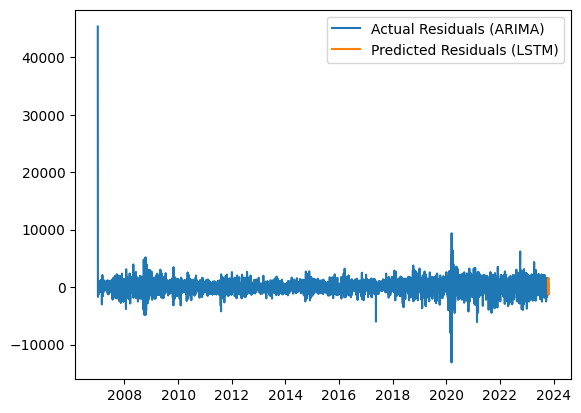

In [35]:
# Get the residuals from the ARIMA model
residuals_arima = model.resid()

# Normalize the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_arima_normalized = scaler.fit_transform(residuals_arima.values.reshape(-1, 1))

# Build an LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(residuals_arima_normalized.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for LSTM input
X_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1, 1))
y_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1))

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=300, batch_size=64)

# Predict the residuals using the LSTM model
X_test = np.reshape(residuals_arima_normalized[-len(data2test):], (len(data2test), 1, 1))
residuals_lstm_normalized = model_lstm.predict(X_test)
residuals_lstm = scaler.inverse_transform(residuals_lstm_normalized)

# Plot the actual residuals and predicted residuals
plt.plot(residuals_arima.index, residuals_arima.values, label='Actual Residuals (ARIMA)')
plt.plot(data2test.index, residuals_lstm, label='Predicted Residuals (LSTM)')
plt.legend()
plt.show()

In [36]:
forecast_df['Forecast Hybrid'] = forecast_df['Forecast'].values+np.hstack(residuals_lstm)
forecast_df['Forecast Hybrid Gru'] = forecast_df['Forecast'].values+np.hstack(residuals_gru)

In [37]:

# Calculate and print the mean squared error
arima_mse = mean_squared_error(data2test['Close'], forecast.values)

arimah_rmse = mean_squared_error(data2test['Close'], forecast_df['Forecast Hybrid'].values)
arimahg_rmse = mean_squared_error(data2test['Close'], forecast_df['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model rmse:",np.sqrt(arimah_rmse))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Gru Model rmse:",np.sqrt(arimahg_rmse))

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(arima_mse))

ARIMA Model rmse: 3417.014332711317
ARIMA Gru Model rmse: 3462.233156953695
GRU Model RMSE:  2907.7372619656153


In [38]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

arima_mape = calculate_mape(data2test['Close'], forecast.values)
arimah_mape = calculate_mape(data2test['Close'], forecast_df['Forecast Hybrid'].values)
arimahg_mape = calculate_mape(data2test['Close'], forecast_df['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAPE: {:.2f}%".format(arimah_mape))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Gru Model MAPE: {:.2f}%".format(arimahg_mape))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAPE: {:.2f}%".format(arima_mape))


ARIMA Model MAPE: 2.85%
ARIMA Gru Model MAPE: 2.89%
ARIMA Model MAPE: 2.49%


In [39]:
def calculate_mae(true_values, predicted_values):
    abs_errors = np.abs(true_values - predicted_values)
    mae = np.mean(abs_errors)
    return mae


# Example usage:
arimah_mae = calculate_mae(data2test['Close'], forecast_df['Forecast Hybrid'].values)
arimahg_mae = calculate_mae(data2test['Close'], forecast_df['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arimah_mae))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arimahg_mae))
# Example usage:
arima_mae = calculate_mae(data2test['Close'], forecast.values)
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arima_mae))

ARIMA Model MAE: 3237.78
ARIMA Model MAE: 3283.94
ARIMA Model MAE: 2829.59


In [40]:
# Calculate the MASE for each model
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

arima_mase = calculate_mase(arima_mae, 1234)
# Example usage:
arimah_mase = calculate_mase(arimah_mae,1234)
arimahg_mase = calculate_mase(arimahg_mae,1234)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MASE: {:.2f}".format(arimah_mase))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA gru Model MASE: {:.2f}".format(arimahg_mase))

# Compare the models using Mean Absolute Scaled Error
print("ARIMA Model MASE: {:.2f}".format(arima_mase))


ARIMA Model MASE: 2.62
ARIMA gru Model MASE: 2.66
ARIMA Model MASE: 2.29


# 15 Dias

In [41]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2test = yf.download('^BVSP', '2023-10-18', '2023-11-09')
data2test= data2test[['Close']]
len(data2test)

[*********************100%%**********************]  1 of 1 completed


15

In [ ]:
data

,Close
Date,
2007-01-02,45383.0
2007-01-03,44445.0
2007-01-04,44020.0
2007-01-05,42245.0
2007-01-08,42830.0
...,...
2023-10-09,115156.0
2023-10-10,116737.0
2023-10-11,117051.0


In [ ]:
data2test

,Close
Date,
2023-10-18,114060.0
2023-10-19,114004.0
2023-10-20,113155.0
2023-10-23,112785.0
2023-10-24,113762.0
2023-10-25,112830.0
2023-10-26,114777.0
2023-10-27,113301.0
2023-10-30,112532.0


In [42]:
# Fit an AutoARIMA model
#model = pm.auto_arima(data, seasonal=True, m=lag)

# Predict the future values
forecast, conf_int = model.predict(n_periods=15, return_conf_int=True)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast.values, index=data2test.index, columns=['Forecast'])

forecast_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Forecast
Date,
2023-10-18,116405.571866
2023-10-19,116482.175213
2023-10-20,116457.567482
2023-10-23,116440.444218
2023-10-24,116483.695212
2023-10-25,116430.583228
2023-10-26,116480.068793
2023-10-27,116443.035161
2023-10-30,116463.855036


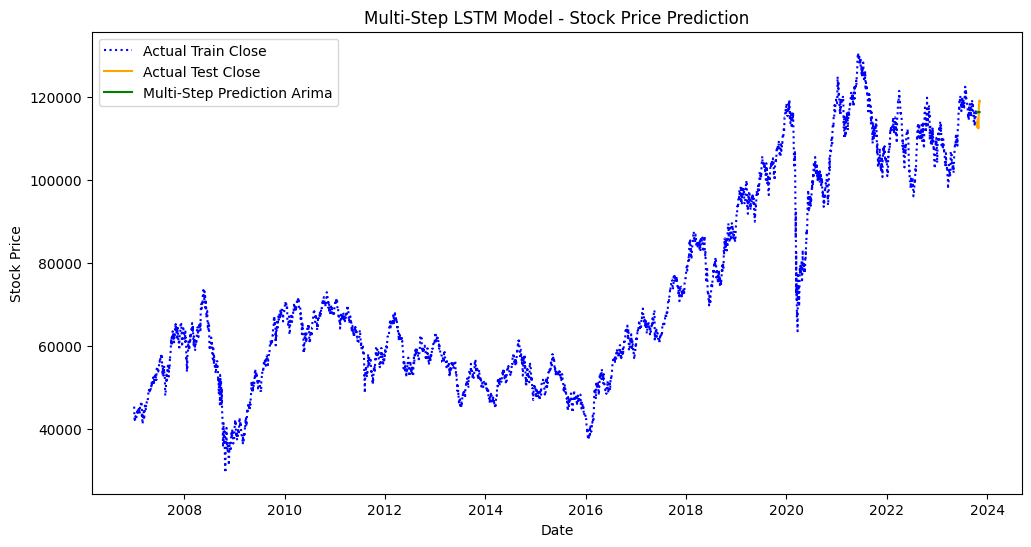

In [43]:
# Generate future dates for the multi-step prediction
#last_date = lagged_data.index[-1]
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_steps)


#Inverse transform both train and test data
#trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
#testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = data.index
time_index_test = data2test.index

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, data, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, data2test, label='Actual Test Close', color='orange')

# Plot the multi-step predictions
#plt.figure(figsize=(12, 6))
#plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(time_index_test, forecast, label='Multi-Step Prediction Arima',color='green')

plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Epoch 1/300
65/65 [==============================] - 7s 8ms/step - loss: 0.0060
Epoch 2/300
65/65 [==============================] - 0s 7ms/step - loss: 3.3000e-04
Epoch 3/300
65/65 [==============================] - 0s 7ms/step - loss: 3.0072e-04
Epoch 4/300
65/65 [==============================] - 1s 15ms/step - loss: 2.6523e-04
Epoch 5/300
65/65 [==============================] - 1s 14ms/step - loss: 2.1999e-04
Epoch 6/300
65/65 [==============================] - 1s 11ms/step - loss: 1.7472e-04
Epoch 7/300
65/65 [==============================] - 1s 12ms/step - loss: 1.2382e-04
Epoch 8/300
65/65 [==============================] - 1s 9ms/step - loss: 7.6752e-05
Epoch 9/300
65/65 [==============================] - 1s 9ms/step - loss: 3.9074e-05
Epoch 10/300
65/65 [==============================] - 0s 6ms/step - loss: 1.6166e-05
Epoch 11/300
65/65 [==============================] - 0s 8ms/step - loss: 5.3764e-06
Epoch 12/300
65/65 [==============================] - 1s 8ms/step - loss: 

1/1 [==============================] - 1s 790ms/step


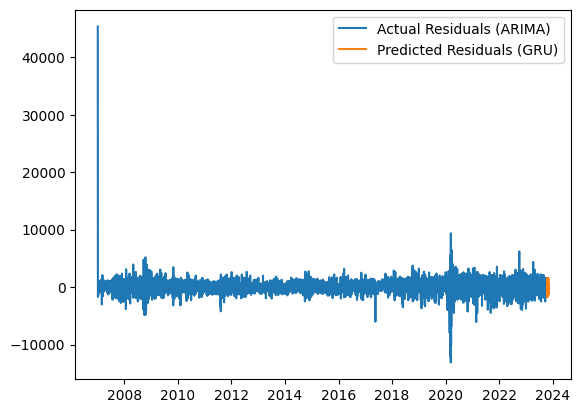

In [44]:
# Get the residuals from the ARIMA model
residuals_arima = model.resid()

# Normalize the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_arima_normalized = scaler.fit_transform(residuals_arima.values.reshape(-1, 1))

# Build a GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(residuals_arima_normalized.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for GRU input
X_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1, 1))
y_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1))

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=300, batch_size=64)

# Predict the residuals using the GRU model
X_test = np.reshape(residuals_arima_normalized[-len(data2test):], (len(data2test), 1, 1))
residuals_gru_normalized = model_gru.predict(X_test)
residuals_gru = scaler.inverse_transform(residuals_gru_normalized)

# Plot the actual residuals and predicted residuals
plt.plot(residuals_arima.index, residuals_arima.values, label='Actual Residuals (ARIMA)')
plt.plot(data2test.index, residuals_gru, label='Predicted Residuals (GRU)')
plt.legend()
plt.show()


Epoch 1/300
65/65 [==============================] - 5s 5ms/step - loss: 0.0137
Epoch 2/300
65/65 [==============================] - 0s 5ms/step - loss: 4.0123e-04
Epoch 3/300
65/65 [==============================] - 0s 5ms/step - loss: 3.7718e-04
Epoch 4/300
65/65 [==============================] - 0s 5ms/step - loss: 3.6181e-04
Epoch 5/300
65/65 [==============================] - 0s 5ms/step - loss: 3.4467e-04
Epoch 6/300
65/65 [==============================] - 0s 5ms/step - loss: 3.2703e-04
Epoch 7/300
65/65 [==============================] - 0s 5ms/step - loss: 2.9900e-04
Epoch 8/300
65/65 [==============================] - 0s 5ms/step - loss: 2.7059e-04
Epoch 9/300
65/65 [==============================] - 0s 5ms/step - loss: 2.3400e-04
Epoch 10/300
65/65 [==============================] - 0s 5ms/step - loss: 1.9108e-04
Epoch 11/300
65/65 [==============================] - 0s 5ms/step - loss: 1.4359e-04
Epoch 12/300
65/65 [==============================] - 0s 5ms/step - loss: 9.52

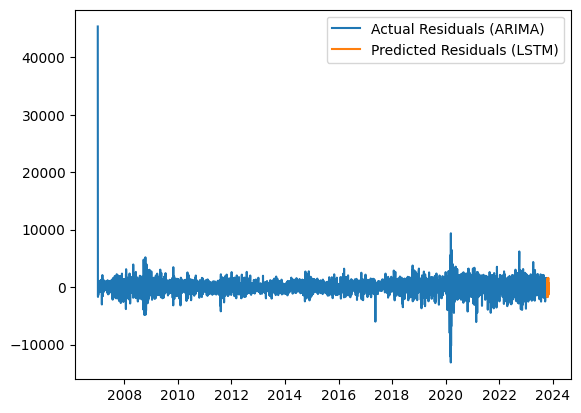

In [45]:
# Get the residuals from the ARIMA model
residuals_arima = model.resid()

# Normalize the residuals
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_arima_normalized = scaler.fit_transform(residuals_arima.values.reshape(-1, 1))

# Build an LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(residuals_arima_normalized.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for LSTM input
X_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1, 1))
y_train = np.reshape(residuals_arima_normalized, (len(residuals_arima_normalized), 1))

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=300, batch_size=64)

# Predict the residuals using the LSTM model
X_test = np.reshape(residuals_arima_normalized[-len(data2test):], (len(data2test), 1, 1))
residuals_lstm_normalized = model_lstm.predict(X_test)
residuals_lstm = scaler.inverse_transform(residuals_lstm_normalized)

# Plot the actual residuals and predicted residuals
plt.plot(residuals_arima.index, residuals_arima.values, label='Actual Residuals (ARIMA)')
plt.plot(data2test.index, residuals_lstm, label='Predicted Residuals (LSTM)')
plt.legend()
plt.show()

In [46]:
forecast_df['Forecast Hybrid'] = forecast_df['Forecast'].values+np.hstack(residuals_lstm)
forecast_df['Forecast Hybrid Gru'] = forecast_df['Forecast'].values+np.hstack(residuals_gru)

In [47]:

# Calculate and print the mean squared error
arima_mse = mean_squared_error(data2test['Close'], forecast.values)

arimah_rmse = mean_squared_error(data2test['Close'], forecast_df['Forecast Hybrid'].values)
arimahg_rmse = mean_squared_error(data2test['Close'], forecast_df['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model rmse:",np.sqrt(arimah_rmse))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Gru Model rmse:",np.sqrt(arimahg_rmse))

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(arima_mse))

ARIMA Model rmse: 2961.6163236223642
ARIMA Gru Model rmse: 2965.1362137590745
GRU Model RMSE:  2820.650606084801


In [48]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

arima_mape = calculate_mape(data2test['Close'], forecast.values)
arimah_mape = calculate_mape(data2test['Close'], forecast_df['Forecast Hybrid'].values)
arimahg_mape = calculate_mape(data2test['Close'], forecast_df['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAPE: {:.2f}%".format(arimah_mape))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Gru Model MAPE: {:.2f}%".format(arimahg_mape))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAPE: {:.2f}%".format(arima_mape))


ARIMA Model MAPE: 2.25%
ARIMA Gru Model MAPE: 2.25%
ARIMA Model MAPE: 2.37%


In [49]:
def calculate_mae(true_values, predicted_values):
    abs_errors = np.abs(true_values - predicted_values)
    mae = np.mean(abs_errors)
    return mae


# Example usage:
arimah_mae = calculate_mae(data2test['Close'], forecast_df['Forecast Hybrid'].values)
arimahg_mae = calculate_mae(data2test['Close'], forecast_df['Forecast Hybrid Gru'].values)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arimah_mae))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arimahg_mae))
# Example usage:
arima_mae = calculate_mae(data2test['Close'], forecast.values)
# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MAE: {:.2f}".format(arima_mae))

ARIMA Model MAE: 2575.39
ARIMA Model MAE: 2578.38
ARIMA Model MAE: 2718.35


In [50]:
# Calculate the MASE for each model
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

arima_mase = calculate_mase(arima_mae, 1285.27)
# Example usage:
arimah_mase = calculate_mase(arimah_mae,1285.27)
arimahg_mase = calculate_mase(arimahg_mae,1285.27)

# Compare the models using Mean Absolute Percentage Error
print("ARIMA Model MASE: {:.2f}".format(arimah_mase))
# Compare the models using Mean Absolute Percentage Error
print("ARIMA gru Model MASE: {:.2f}".format(arimahg_mase))

# Compare the models using Mean Absolute Scaled Error
print("ARIMA Model MASE: {:.2f}".format(arima_mase))


ARIMA Model MASE: 2.00
ARIMA gru Model MASE: 2.01
ARIMA Model MASE: 2.12
